In [1]:
from feature_engine import FeatureEngine
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
import shap

/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = FeatureEngine()

In [3]:
dataset.training_set.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,id,corresponding_day,06:00:00,06:05:00,06:10:00,06:15:00,...,mean_last_1_hour,mean_last_3_hours,mean_last_6_hours,mean_last_12_hours,std_last_10_minutes,std_last_30_minutes,std_last_1_hour,std_last_3_hours,std_last_6_hours,std_last_12_hours
0,0,0,0,0,2,2015-05-23,163.0,159.0,155.0,152.0,...,81.666667,107.333333,136.615741,133.260417,2.5,1.707825,2.494438,27.331301,37.444925,42.276513
1,1,1,1,1,2,2015-05-24,214.0,215.0,221.0,231.0,...,167.666667,223.319444,236.979167,194.031250,2.5,20.974190,55.993055,52.023920,46.057063,56.216416
2,2,2,2,2,2,2015-05-25,115.0,114.0,116.0,118.0,...,133.583333,221.152778,239.229167,187.093750,2.5,11.756795,25.869732,71.386115,66.889134,72.226244
3,3,3,3,3,2,2015-05-26,206.0,207.0,207.0,209.0,...,141.750000,175.916667,190.395833,214.847222,0.0,1.154701,4.656984,32.263994,35.729495,54.339413
4,4,4,4,4,2,2015-05-27,169.0,171.0,173.0,173.0,...,115.583333,149.250000,153.583333,172.000000,0.5,1.490712,3.012705,32.271741,37.434202,57.318161


In [4]:
training_X = dataset.training_set.iloc[:,223:]
validation_X = dataset.validation_set.iloc[:,221:]
training_Y = dataset.training_set.iloc[:, 222]
validation_Y = dataset.validation_set.iloc[:, 220]

In [5]:
print(training_Y)

0        False
1        False
2        False
3        False
4        False
         ...  
29809    False
29810    False
29811    False
29812    False
29813    False
Name: hypo, Length: 29814, dtype: bool


In [6]:
numerical_cols = []
categorical_cols = []

for column in training_X.columns:
    if any(sub in column for sub in ['last_', 'Weight', 'Height']):
        numerical_cols.append(column)
    elif any(sub in column for sub in ['Gender', 'Ethnicity', 'Race', 'SHMostRec', 'SHNumLast12Mon', 'DKAMostRec', 'DKANumLast12Mon', 'OthGlucLowerMed', 'PEAbnormal', 'Day_', 'Month_', 'Year_']):
        categorical_cols.append(column)
    else:
        # If unsure, you might print out or manually inspect the column
        print("Unclassified column:", column)

# Print out your sorted columns (optional)
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['mean_diff_last_10_minutes', 'mean_diff_last_30_minutes', 'mean_diff_last_1_hour', 'mean_diff_last_3_hours', 'mean_diff_last_6_hours', 'mean_diff_last_12_hours', 'gri_last_10_minutes', 'gri_last_30_minutes', 'gri_last_1_hour', 'gri_last_3_hours', 'gri_last_6_hours', 'gri_last_12_hours', 'tbr_last_10_minutes', 'tbr_last_30_minutes', 'tbr_last_1_hour', 'tbr_last_3_hours', 'tbr_last_6_hours', 'tbr_last_12_hours', 'tar_last_10_minutes', 'tar_last_30_minutes', 'tar_last_1_hour', 'tar_last_3_hours', 'tar_last_6_hours', 'tar_last_12_hours', 'tir_last_10_minutes', 'tir_last_30_minutes', 'tir_last_1_hour', 'tir_last_3_hours', 'tir_last_6_hours', 'tir_last_12_hours', 'mean_last_10_minutes', 'mean_last_30_minutes', 'mean_last_1_hour', 'mean_last_3_hours', 'mean_last_6_hours', 'mean_last_12_hours', 'std_last_10_minutes', 'std_last_30_minutes', 'std_last_1_hour', 'std_last_3_hours', 'std_last_6_hours', 'std_last_12_hours']
Categorical Columns: []


In [7]:
print(training_Y)
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(training_X, training_Y)

0        False
1        False
2        False
3        False
4        False
         ...  
29809    False
29810    False
29811    False
29812    False
29813    False
Name: hypo, Length: 29814, dtype: bool


In [8]:
bst = XGBClassifier(objective="binary:logistic", eval_metric="auc")
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
validation_X['Year_2014'] = 0
#validation_X.drop(columns=['Year_2013'], inplace=True)
cols = np.array(training_X.columns)
validation_X = validation_X[cols]

In [11]:
preds = bst.predict(validation_X)

def safe_convert_to_float(array):
    try:
        return array.astype(float)
    except ValueError:
        # If conversion fails, attempt to coerce manually, substituting NaNs for unconvertible entries
        converted = np.array([float(x) if isinstance(x, (int, float)) else np.nan for x in array])
        return converted

# Convert both arrays, handling non-convertible types
validation_Y = safe_convert_to_float(validation_Y)
preds = safe_convert_to_float(preds)

# Find indices where either array has a NaN
nan_indices = np.where(np.isnan(validation_Y) | np.isnan(preds))[0]

# Remove the indices with NaNs from both arrays
validation_Y_clean = np.delete(validation_Y, nan_indices)
preds_clean = np.delete(preds, nan_indices)

# Now you can compute roc_auc_score without encountering NaN issues
roc_auc_score(validation_Y_clean, preds_clean)


0.5037890223673713

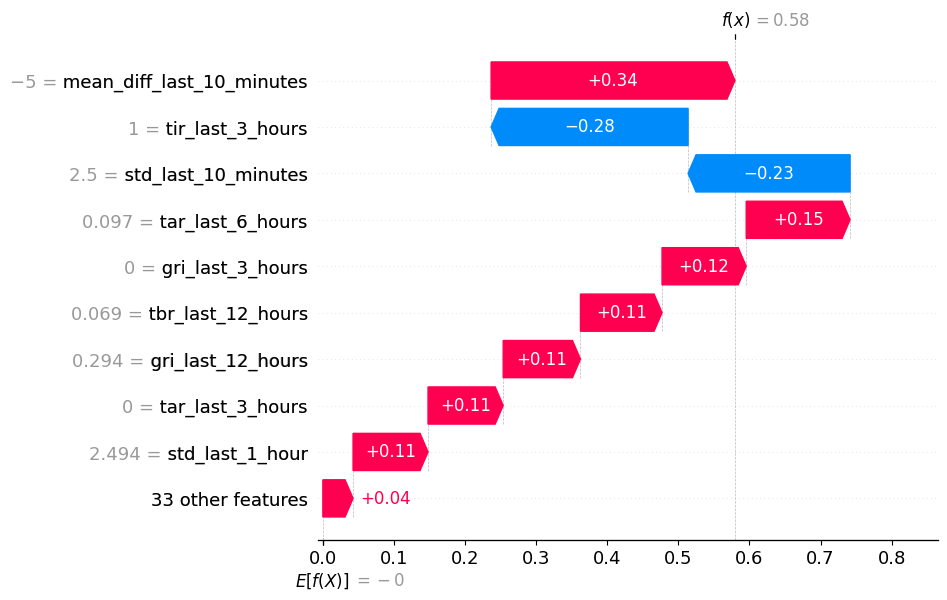

In [12]:
explainer = shap.Explainer(bst)
shap_values = explainer(x_train)
shap.plots.waterfall(shap_values[0])

In [7]:
selector = SequentialFeatureSelector(XGBClassifier(objective="binary:logistic", eval_metric="auc") ,n_features_to_select=10, direction='forward', scoring="roc_auc", cv=10)

selector.fit_transform(x_train,y_train)

KeyboardInterrupt: 

In [23]:
selector.get_feature_names_out()

array(['fft_last_3_hours_real_8', 'fft_last_3_hours_mag_33',
       'fft_last_6_hours_phase_30', 'fft_last_12_hours_imag_37',
       'fft_last_12_hours_phase_41', 'fft_last_12_hours_phase_45',
       'fft_last_12_hours_imag_52', 'fft_last_12_hours_phase_89',
       'fft_last_12_hours_real_124', 'Height'], dtype=object)

In [24]:
selector.get_support()

array([False, False, False, ..., False, False, False])

In [25]:
x_train.head()

,gri_last_10_minutes,gri_last_30_minutes,gri_last_1_hour,gri_last_3_hours,gri_last_6_hours,gri_last_12_hours,tbr_last_10_minutes,tbr_last_30_minutes,tbr_last_1_hour,tbr_last_3_hours,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Year_2014,Year_2015,Year_2016
0,0.0,0.0,0.0,0.000000,0.077778,0.294444,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,0.0,0.4,0.977778,1.088889,0.600000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.888889,1.055556,0.527778,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,0.0,0.0,0.333333,0.477778,0.738889,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,0.0,0.200000,0.255556,0.444444,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [26]:
x_t = selector.transform(training_X)

In [27]:
validation_X['Year_2014'] = 0
#validation_X.drop(columns=['Year_2013'], inplace=True)
cols = np.array(training_X.columns)
validation_X = validation_X[cols]
x_val = selector.transform(validation_X)

In [29]:
preds = bst.predict(x_val)

In [41]:
def safe_convert_to_float(array):
    try:
        return array.astype(float)
    except ValueError:
        # If conversion fails, attempt to coerce manually, substituting NaNs for unconvertible entries
        converted = np.array([float(x) if isinstance(x, (int, float)) else np.nan for x in array])
        return converted

# Convert both arrays, handling non-convertible types
validation_Y = safe_convert_to_float(validation_Y)
preds = safe_convert_to_float(preds)

# Find indices where either array has a NaN
nan_indices = np.where(np.isnan(validation_Y) | np.isnan(preds))[0]

# Remove the indices with NaNs from both arrays
validation_Y_clean = np.delete(validation_Y, nan_indices)
preds_clean = np.delete(preds, nan_indices)

# Now you can compute roc_auc_score without encountering NaN issues
roc_auc_score_result = roc_auc_score(validation_Y_clean, preds_clean)


In [42]:
print(roc_auc_score_result)

0.5015316225384125


In [28]:
bst = XGBClassifier(objective="binary:logistic", eval_metric="auc")
bst.fit(x_t, training_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
preds = bst.predict(x_t)
roc_auc_score(training_Y, preds)

0.5484027572237877

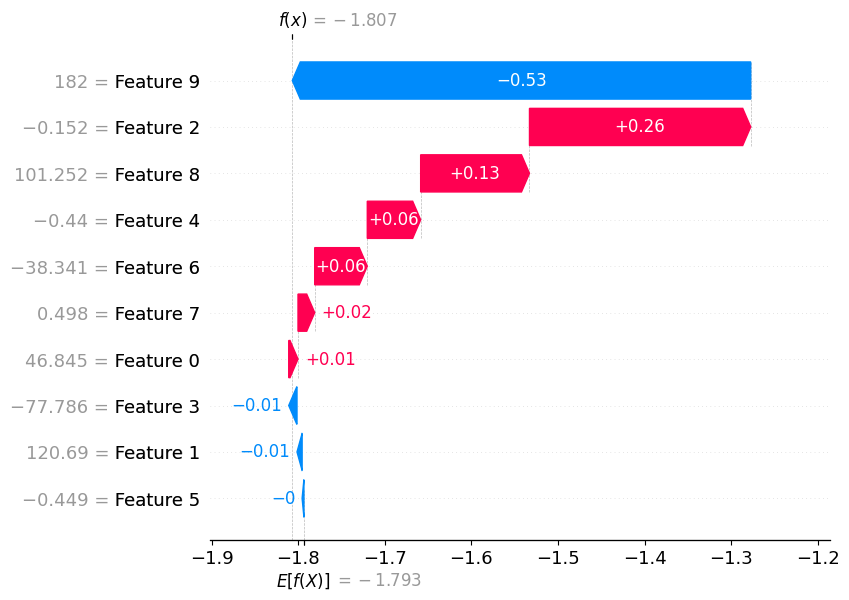

In [33]:
explainer = shap.Explainer(bst)
shap_values = explainer(x_t)
shap.plots.waterfall(shap_values[0])

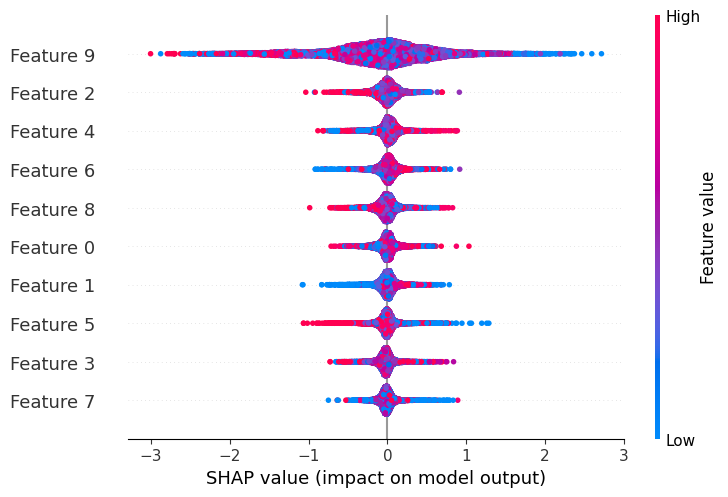

In [34]:
shap.plots.beeswarm(shap_values)

In [23]:
selector_2 = SequentialFeatureSelector(XGBClassifier(objective="binary:logistic", eval_metric="auc") ,n_features_to_select=30, direction='forward', scoring="roc_auc", cv=10)

selector_2.fit_transform(x_train,y_train)

array([[ 1.        , 42.2765126 , -0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , 56.21641648, -0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , 72.22624379, -0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.        , 25.81213638,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , 57.23443733,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        , 42.2765126 ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [25]:
x_train_transfor = selector_2.transform(training_X)

In [45]:
bst.fit(x_train_transfor, training_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
y_val_transformed = selector.transform(validation_X)
preds = bst.predict(y_val_transformed)
roc_auc_score(validation_Y, preds)

/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SequentialFeatureSelector was fitted without feature names
  warnings.warn(
/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/sklearn/utils/_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.